# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.

## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import imagehash
from IPython.display import FileLink

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from skimage.util import random_noise
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 0


## ⏳ Load the Data

In [ ]:
data = np.load("/content/drive/MyDrive/mars_for_students.npz")

print(data.files)
print(f"Training set shape: {data['training_set'].shape}")
print(f"Test set shape: {data['test_set'].shape}")

['training_set', 'test_set']
Training set shape: (2615, 2, 64, 128)
Test set shape: (10022, 64, 128)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Split the files provided. As shown in the previous cell, the test set has
# no labels
training_set = data["training_set"]
X_data = training_set[:, 0]
y_data = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_data.shape}")
print(f"Training y shape: {y_data.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Verify the minimum and maximum values in X_data and X_test
print("Original data range:")
print(f"X_data: Min = {X_data.min()}, Max = {X_data.max()}")
print(f"X_test: Min = {X_test.min()}, Max = {X_test.max()}")

Original data range:
X_data: Min = 2.0, Max = 254.0
X_test: Min = 1, Max = 255


In [ ]:
input_shape = (64, 128, 1)
output_shape = len(np.unique(y_data))

print(f"Output shape: {output_shape}")

Output shape: 5


Number of pixels and percentage distribution per class:
Class 0: 5466886 pixels (25.52%)
Class 1: 7131118 pixels (33.29%)
Class 2: 4863930 pixels (22.71%)
Class 3: 3933183 pixels (18.36%)
Class 4: 26963 pixels (0.13%)


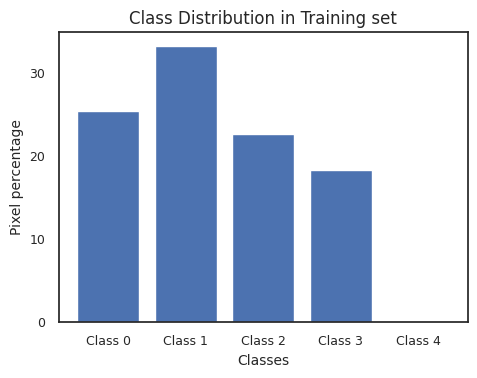

In [ ]:
# Count the number of pixels for each class
class_counts = np.zeros(output_shape, dtype=int)
for mask in y_data:
    class_counts += np.bincount(mask.flatten().astype(int), minlength=output_shape)

# Calculate the proportion of pixels for each class
total_pixels = class_counts.sum()
class_distribution = class_counts / total_pixels

# Print the results in a formatted way
print("Number of pixels and percentage distribution per class:")
for class_index, (count, percentage) in enumerate(zip(class_counts, class_distribution * 100)):
    print(f"Class {class_index}: {count} pixels ({percentage:.2f}%)")

# Plot the distribution
class_labels = [f"Class {i}" for i in range(output_shape)]

plt.figure(figsize=(5, 4))
plt.bar(class_labels, class_distribution * 100)
plt.xlabel("Classes", fontsize=10)
plt.ylabel("Pixel percentage", fontsize=10)
plt.title("Class Distribution in Training set", fontsize=12)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

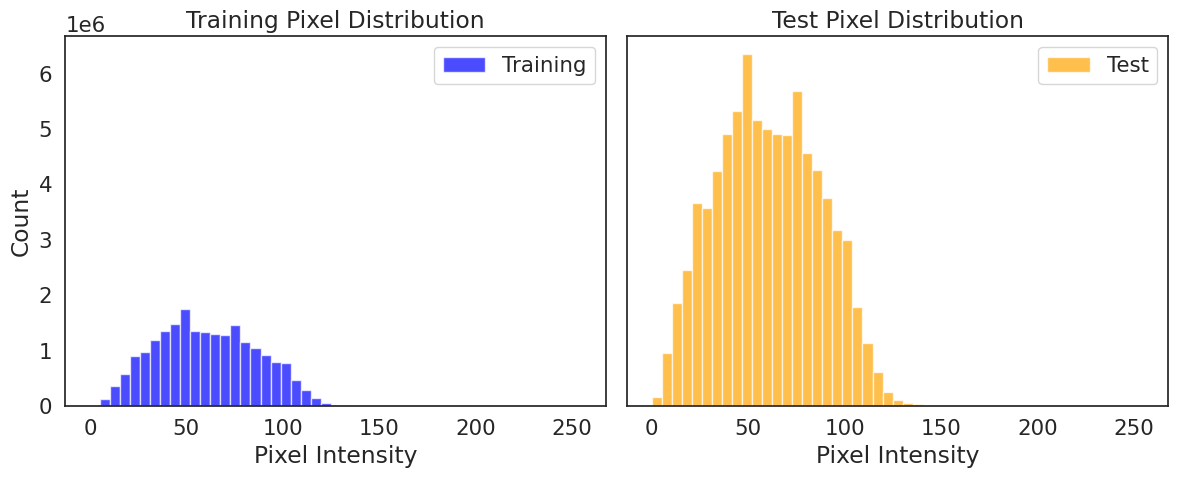

In [ ]:
# Calculate histograms
bins = np.linspace(0, 255, 50)  # Define 50 bins between 0 and 255
train_hist, _ = np.histogram(X_data.flatten(), bins=bins)
test_hist, _ = np.histogram(X_test.flatten(), bins=bins)

# Create two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Same y-axis for easier comparison

# Training histogram
axs[0].hist(X_data.flatten(), bins=bins, color='blue', alpha=0.7, label="Training")
axs[0].set_title("Training Pixel Distribution")
axs[0].set_xlabel("Pixel Intensity")
axs[0].set_ylabel("Count")
axs[0].legend()

# Test histogram
axs[1].hist(X_test.flatten(), bins=bins, color='orange', alpha=0.7, label="Test")
axs[1].set_title("Test Pixel Distribution")
axs[1].set_xlabel("Pixel Intensity")
axs[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
# Dictionary for the classes names
class_names = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}

In [ ]:
def display_random_samples(images, masks=None, class_names=None, num_samples=None, fontsize=None):
    """
    Display random samples of images and masks with accurate colormap and legend.
    """
    # Define figure size and grid layout. Two columns if masks exist, otherwise one
    cols = 3 if masks is not None else 1  # Aggiungi una colonna extra per la legenda
    fig = plt.figure(figsize=(12, num_samples * 4))  # Modifica la dimensione del grafico
    gs = gridspec.GridSpec(num_samples, cols, hspace=0.3, wspace=0.4)

    for i in range(num_samples):
        # Select a random index
        idx = random.randint(0, len(images) - 1)

        # Plot the image
        ax1 = fig.add_subplot(gs[i, 0])
        ax1.imshow(images[idx].squeeze(), cmap='gray')
        ax1.set_title(f"Image {idx}", fontsize=fontsize)
        ax1.axis('off')

        if masks is not None:
            # Plot the corresponding mask
            ax2 = fig.add_subplot(gs[i, 1])
            mask = masks[idx].squeeze()

            # Ensure mask values are integers corresponding to class indices
            mask = mask.astype(int)

            # Plot the mask with a proper colormap
            num_classes = len(class_names)
            colormap = plt.cm.get_cmap("viridis", num_classes)
            ax2.imshow(mask, cmap=colormap, vmin=0, vmax=num_classes - 1)
            ax2.set_title(f"Mask {idx}", fontsize=fontsize)
            ax2.axis('off')

            # Add legend in a separate subplot
            ax3 = fig.add_subplot(gs[i, 2])
            ax3.axis('off')  # Rimuove gli assi per la legenda

            # Create legend elements
            legend_elements = [
                mpatches.Patch(color=colormap(c / (num_classes - 1)), label=class_names[c])
                for c in range(num_classes)
            ]

            # Add the legend to the figure
            ax3.legend(
                handles=legend_elements,
                loc="center",
                fontsize=fontsize,
                frameon=False
            )

    plt.tight_layout(pad=0.5)
    plt.show()

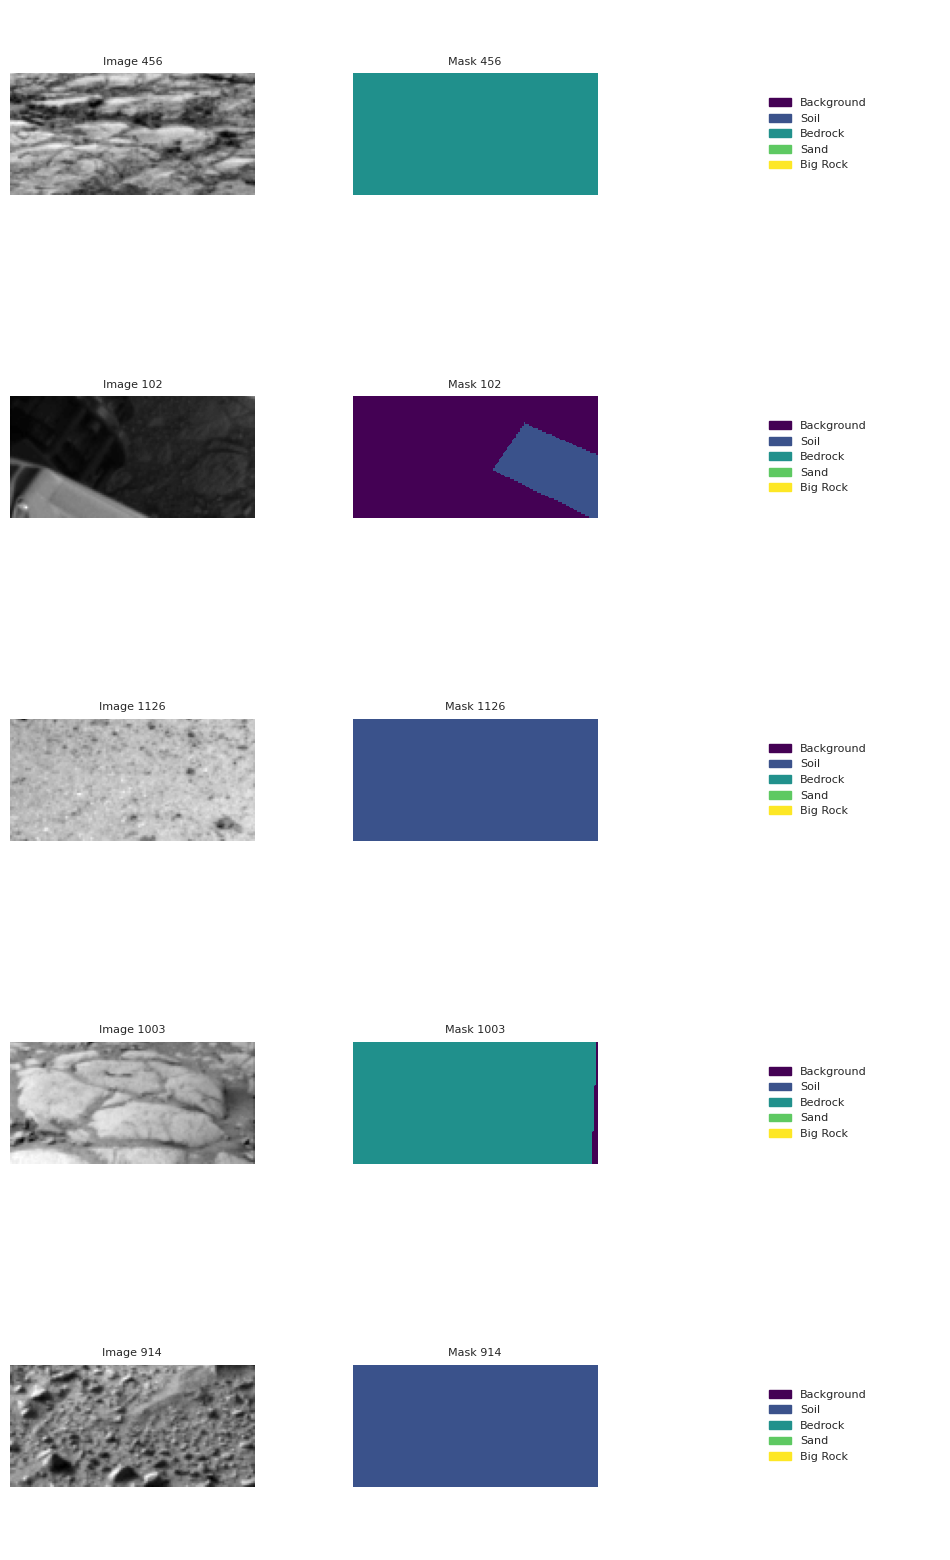

In [ ]:
# Visualize 5 random samples
display_random_samples(X_data, masks=y_data, class_names=class_names, num_samples=5, fontsize=8)

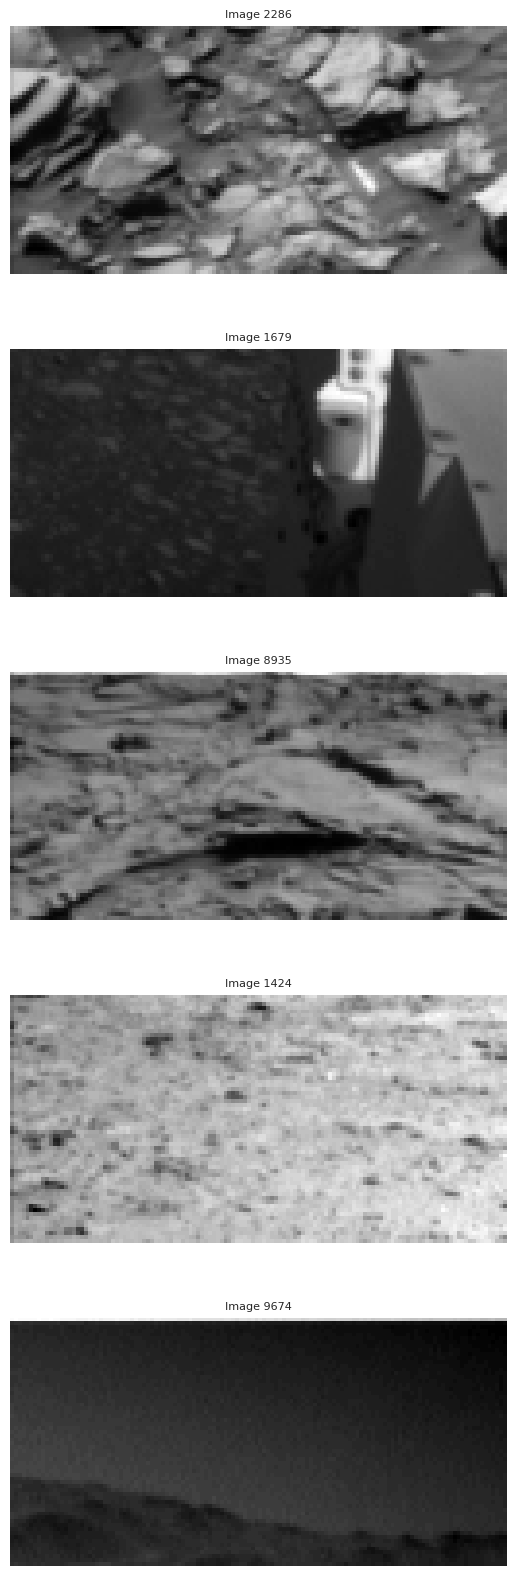

In [ ]:
# Visualize 5 random samples from the test set (without masks)
display_random_samples(X_test, num_samples=5, fontsize=8)

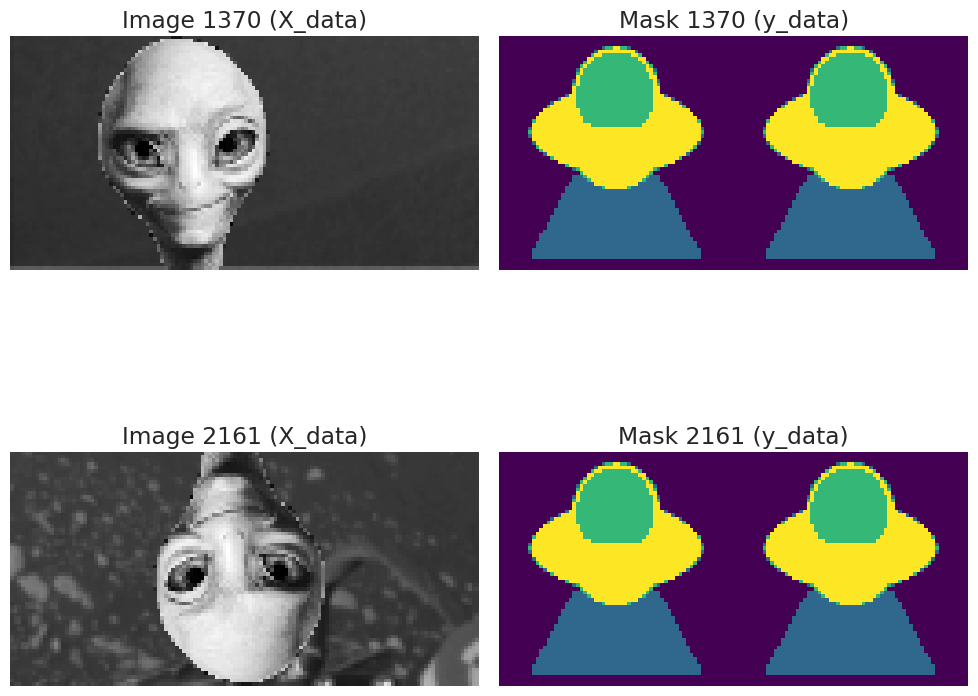

In [ ]:
# Indices of the images and masks to inspect
sample_indices = [1370, 2161]

# Set up the plot for multiple images and masks
plt.figure(figsize=(10, len(sample_indices) * 5))  # Adjust the height based on the number of samples

for i, sample_index in enumerate(sample_indices):
    # Display the image
    plt.subplot(len(sample_indices), 2, i * 2 + 1)
    plt.imshow(X_data[sample_index].squeeze(), cmap='gray')  # cmap='gray' for grayscale images
    plt.title(f"Image {sample_index} (X_data)")
    plt.axis('off')

    # Display the mask
    plt.subplot(len(sample_indices), 2, i * 2 + 2)
    plt.imshow(y_data[sample_index].squeeze(), cmap='viridis')  # cmap='viridis' for masks
    plt.title(f"Mask {sample_index} (y_data)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Alien image mask used as a reference
mask_reference = y_data[1370]
mask_tuple = tuple(mask_reference.flatten())

# Find all the duplicate images
duplicate_indices = [
    idx for idx, mask in enumerate(y_data)
    if tuple(mask.flatten()) == mask_tuple
]

print(f"Found {len(duplicate_indices)} images with identical masks to the reference.")

# Filter the dataset deleting the duplicate images
original_size = len(y_data)
remaining_indices = [idx for idx in range(len(y_data)) if idx not in duplicate_indices]
X_data = X_data[remaining_indices]
y_data = y_data[remaining_indices]


print(f"Original dataset size: {original_size}")
print(f"Filtered dataset size: {len(y_data)}")
print(f"Number of removed images: {len(duplicate_indices)}")

Found 110 images with identical masks to the reference.
Original dataset size: 2615
Filtered dataset size: 2505
Number of removed images: 110


Number of masks with 'Big Rock' class: 63


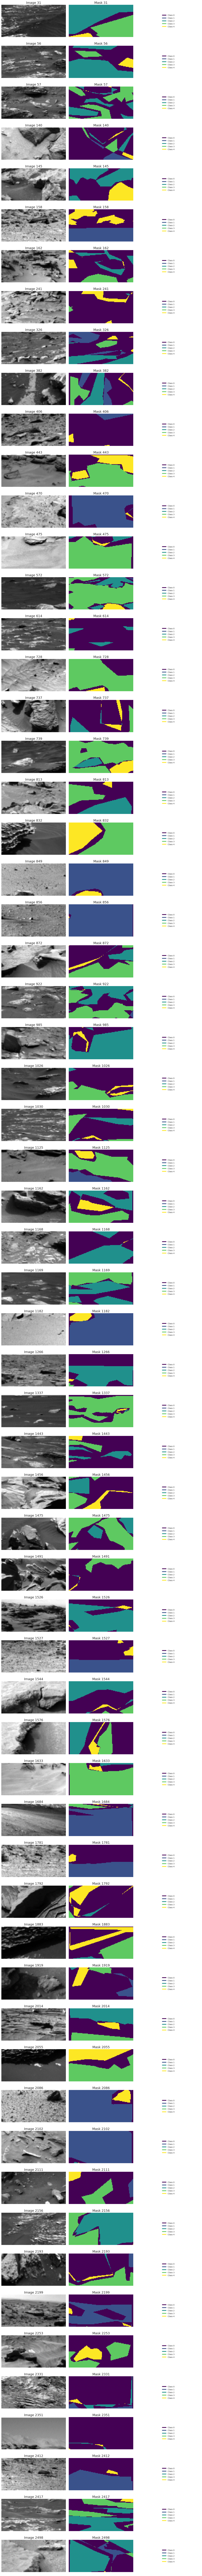

In [ ]:
# Define the class index for "Big Rock"
big_rock_class = 4

# Find indices of masks where the "Big Rock" class is present
indices_with_big_rock = [
    idx for idx, mask in enumerate(y_data)
    if big_rock_class in mask
]

# Print the number of masks containing the "Big Rock" class
print(f"Number of masks with 'Big Rock' class: {len(indices_with_big_rock)}")

# Set up a grid to visualize all images and masks
num_samples = len(indices_with_big_rock)
fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))

for i, idx in enumerate(indices_with_big_rock):
    # Get the image and mask
    image = X_data[idx]
    mask = y_data[idx].astype(int)

    # Plot the image
    axes[i, 0].imshow(image.squeeze(), cmap='gray')
    axes[i, 0].set_title(f"Image {idx}")
    axes[i, 0].axis('off')

    # Plot the mask with proper colormap
    colormap = plt.cm.get_cmap("viridis", len(class_labels))
    axes[i, 1].imshow(mask.squeeze(), cmap=colormap, vmin=0, vmax=len(class_labels) - 1)
    axes[i, 1].set_title(f"Mask {idx}")
    axes[i, 1].axis('off')

    # Add a legend specific to this mask
    legend_elements = [
        plt.Line2D([0], [0], color=colormap(c / len(class_labels)), lw=4, label=class_labels[c])
        for c in range(len(class_labels))
    ]
    axes[i, 2].axis('off')  # Turn off axes for the legend
    axes[i, 2].legend(handles=legend_elements, loc='center', fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the class distribution for each mask
class_profiles_data = np.array([
    np.bincount(mask.flatten().astype(int), minlength=output_shape) / mask.size
    for mask in y_data
])

# Perform a split in train_val and test while respecting the distribution
X_train_val, X_our_test, y_train_val, y_our_test = train_test_split(
    X_data, y_data,
    test_size=0.2,
    random_state=seed,
    stratify=class_profiles_data.argmax(axis=1)
)

# Compute again the class distribution for each mask
class_profiles_train_val = np.array([
    np.bincount(mask.flatten().astype(int), minlength=output_shape) / mask.size
    for mask in y_train_val
])

# Perform a split in train and validation while respecting the distribution
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,  # 25% is equal to the 20% of total
    random_state=seed,
    stratify=class_profiles_train_val.argmax(axis=1)
)

# Controlla la distribuzione
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_our_test)} samples")

Training set: 1503 samples
Validation set: 501 samples
Test set: 501 samples


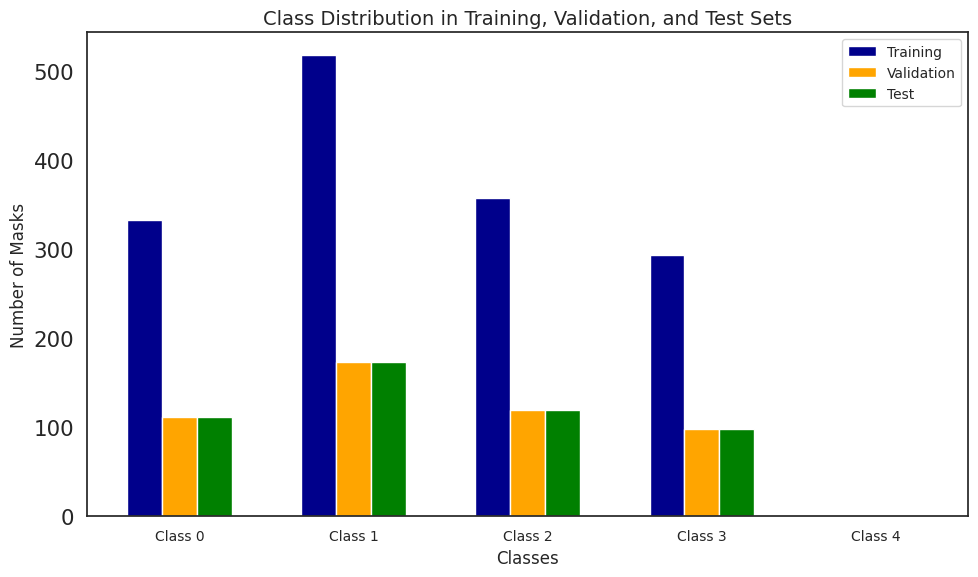

In [ ]:
# Function to compute and display class distribution
def compute_class_distribution(y, output_shape):
    # Flatten the labels to predominant classes per mask
    y_flat = np.array([np.argmax(np.bincount(mask.flatten().astype(int), minlength=output_shape)) for mask in y])

    # Count the number of masks for each class
    predominant_classes, class_counts = np.unique(y_flat, return_counts=True)

    # Create a dictionary to include all classes, even those with zero counts
    class_distribution = {class_label: 0 for class_label in range(output_shape)}
    for label, count in zip(predominant_classes, class_counts):
        class_distribution[label] = count

    return class_distribution

# Compute class distribution for training, validation, and test sets
train_distribution = compute_class_distribution(y_train, output_shape)
val_distribution = compute_class_distribution(y_val, output_shape)
test_distribution = compute_class_distribution(y_our_test, output_shape)

# Prepare data for visualization
labels = [f"Class {i}" for i in range(output_shape)]
train_counts = [train_distribution[i] for i in range(output_shape)]
val_counts = [val_distribution[i] for i in range(output_shape)]
test_counts = [test_distribution[i] for i in range(output_shape)]

# Plot the distributions
x = np.arange(output_shape)  # Class indices

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, train_counts, width=0.2, label='Training', color='darkblue')
plt.bar(x, val_counts, width=0.2, label='Validation', color='orange')
plt.bar(x + 0.2, test_counts, width=0.2, label='Test', color='green')
plt.xticks(x, labels, fontsize=10)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Masks", fontsize=12)
plt.title("Class Distribution in Training, Validation, and Test Sets", fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Define the augmentation parameters
augmentation_params = {
    "rotation_range": 30,
    "width_shift_range": 0.2,
    "height_shift_range": 0.2,
    "zoom_range": 0.3,
    "horizontal_flip": True,
    "fill_mode": "reflect",
}

# Create a single data generator for both images and masks
data_gen = ImageDataGenerator(**augmentation_params)

# Set augmentation factors
general_augmentation_factor = 2  # General augmentation factor for all classes
big_rock_augmentation_factor = 4  # Higher augmentation factor for "Big Rock" (class 4)

# Initialize lists to store augmented images and masks
augmented_X_train = []
augmented_y_train = []

# Debug counters
big_rock_images = 0
general_images = 0

In [ ]:
# Loop over the original images and masks
for i, (image, mask) in enumerate(zip(X_train, y_train)):
    # Expand dimensions to simulate a batch of size 1
    image = image[np.newaxis, ..., np.newaxis]  # Add channel dimension (for grayscale)
    mask = mask[np.newaxis, ..., np.newaxis]    # Add channel dimension (for segmentation masks)

    # Check if "Big Rock" (class 4) is present in the mask
    if 4 in np.unique(mask):
        augmentation_factor = big_rock_augmentation_factor
        big_rock_images += 1
    else:
        augmentation_factor = general_augmentation_factor
        general_images += 1

    # Create augmentation generators (synchronized)
    gen = data_gen.flow(
        np.concatenate([image, mask], axis=-1),
        batch_size=1,
        seed=i
    )

    # Generate `augmentation_factor` new images and masks
    for _ in range(augmentation_factor):
        augmented_pair = next(gen)[0]  # Extract augmented pair (image + mask)
        augmented_image = augmented_pair[..., 0]  # Extract augmented image
        augmented_mask = augmented_pair[..., 1]  # Extract augmented mask

        # Add slight random noise to the image for diversity
        #augmented_image = random_noise(augmented_image, mode="gaussian", var=0.001)

        # Ensure the mask values are integers (class labels)
        augmented_mask = np.round(augmented_mask).astype(int)

        # Append augmented data to the lists
        augmented_X_train.append(augmented_image)
        augmented_y_train.append(augmented_mask)

# Convert the augmented data to numpy arrays
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

In [ ]:
# Combine original and augmented data
X_train = np.concatenate([X_train, augmented_X_train])
y_train = np.concatenate([y_train, augmented_y_train])

# Debug: Print statistics
print(f"Original training set size: {len(X_train)}")
print(f"Images with 'Big Rock' class: {big_rock_images}")
print(f"General images: {general_images}")
print(f"Augmented training set size: {len(augmented_X_train)}")
print(f"Final training set size: {len(X_train)}")


Original training set size: 4589
Images with 'Big Rock' class: 40
General images: 1463
Augmented training set size: 3086
Final training set size: 4589


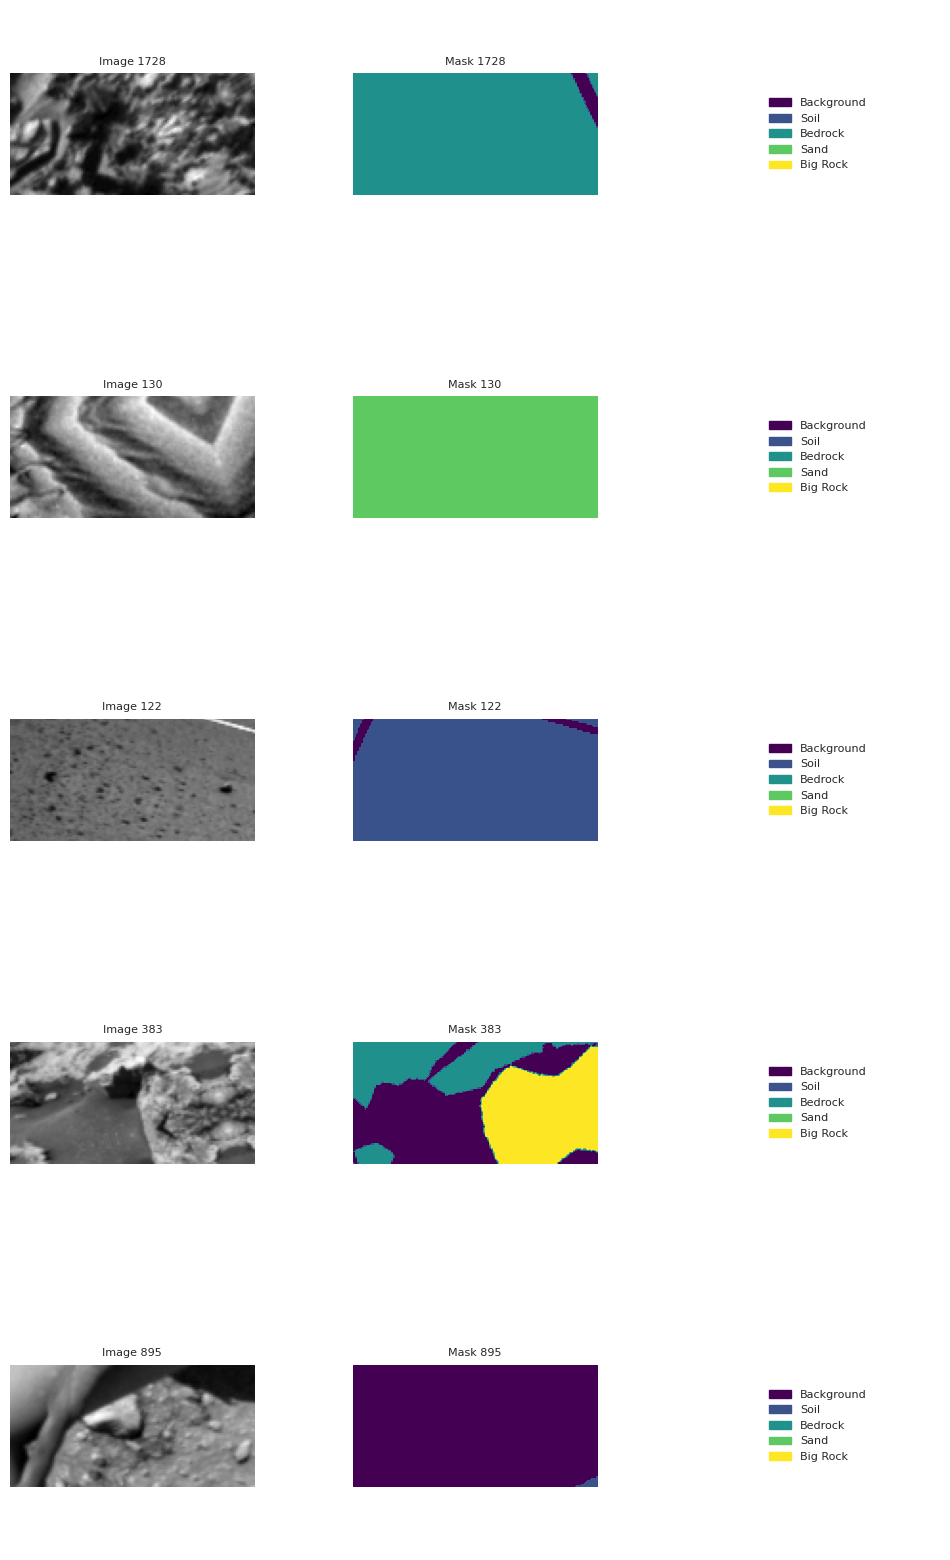

In [ ]:
# Visualize 5 random samples
display_random_samples(augmented_X_train, masks=augmented_y_train, class_names=class_names, num_samples=5, fontsize=8)

In [ ]:
train_min = X_train.min()
train_max = X_train.max()

val_min = X_val.min()
val_max = X_val.max()

test_min = X_test.min()
test_max = X_test.max()

our_test_min = X_our_test.min()
our_test_max = X_our_test.max()

# Add color channel and rescale pixels between 0 and 1
X_train = (X_train - train_min) / (train_max - train_min)
X_train = X_train[..., np.newaxis]

X_val = (X_val - val_min) / (val_max - val_min)
X_val = X_val[..., np.newaxis]

X_our_test = (X_our_test - our_test_min) / (our_test_max - our_test_min)
X_our_test = X_our_test[..., np.newaxis]

X_test = (X_test - test_min) / (test_max - test_min)
X_test = X_test[..., np.newaxis]


input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_data))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_our_test shape: {X_our_test.shape}")
print(f"y_our_test shape: {y_our_test.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (4589, 64, 128, 1)
y_train shape: (4589, 64, 128)
X_val shape: (501, 64, 128, 1)
y_val shape: (501, 64, 128)
X_our_test shape: (501, 64, 128, 1)
y_our_test shape: (501, 64, 128)
X_test shape: (10022, 64, 128, 1)


In [ ]:
print(f"Training set: Min = {X_train.min()}, Max = {X_train.max()}")
print(f"Validation set: Min = {X_val.min()}, Max = {X_val.max()}")
print(f"Our Test set: Min = {X_our_test.min()}, Max = {X_our_test.max()}")
print(f"Test set: Min = {X_test.min()}, Max = {X_test.max()}")

Training set: Min = 0.0, Max = 1.0
Validation set: Min = 0.0, Max = 1.0
Our Test set: Min = 0.0, Max = 1.0
Test set: Min = 0.0, Max = 1.0


In [ ]:
np.savez_compressed("mars_datasets_aug.npz",
                    X_train=X_train,
                    y_train=y_train,
                    X_val=X_val,
                    y_val=y_val,
                    X_our_test = X_our_test,
                    y_our_test = y_our_test,
                    X_test=X_test)


FileLink("mars_datasets_aug.npz")

/kaggle/working/mars_datasets_aug.npz